# Loading Trained Model

In [7]:
import torch
from src.LogViewer import LogViewer
from src.Earlystopper import EarlyStopper

from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR

In [8]:
"""Dataset selection"""
# DATASET = "CIFAR10"
# DATASET = "CIFAR100"
DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"


file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"MyResNet34_{BATCH}_{OPTIMIZER}"
    _model_name = f"MyResNet34_{DATASET}_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    _model_name = f"MyResNet{NUM_LAYERS_LEVEL*6+2}_{DATASET}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    _model_name += f"_{int(SPLIT_RATIO*100)}"
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [9]:
checkpoint = torch.load(
    "models/"+_model_name+"/"+file_path + ".pth.tar",
    map_location=lambda storage, loc: storage.cuda("cuda"),
)

logs = checkpoint["logs"]

print("Suceessfully loaded the All setting and Log file.")

Suceessfully loaded the All setting and Log file.


In [10]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=10,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to("cuda")
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=1000, Downsample_option="B").to("cuda")
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

earlystopper = EarlyStopper(patience=999, model=model, file_path=file_path)
earlystopper.load_state_dict(checkpoint["earlystopper"])

ResNet-34 for ImageNet2012 is loaded.


In [11]:
earlystopper.early_stop_counter

0

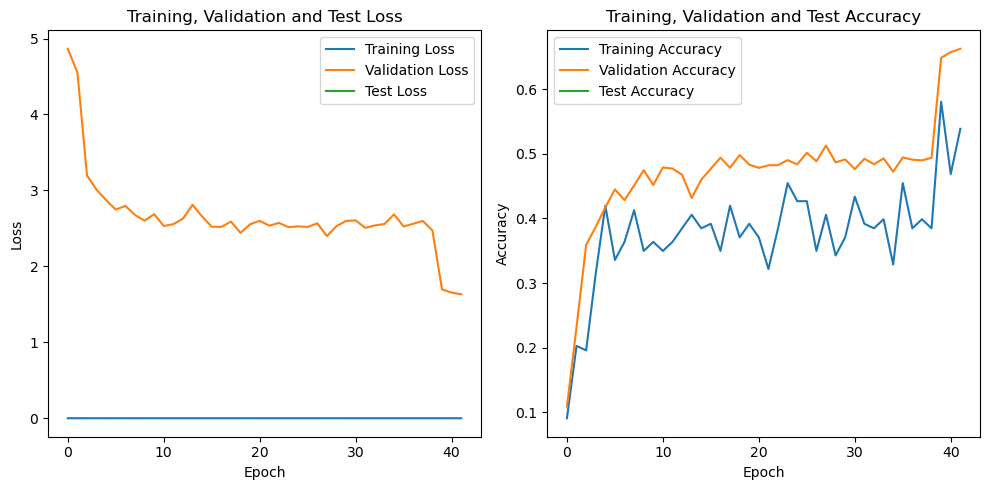

In [12]:
viewer = LogViewer(logs)
# viewer.draw(start=4980, range=200)
viewer.draw()

In [13]:
viewer.print_len()

Num of train logs :  42
Num of train logs :  42
Num of valid logs :  42
Num of valid logs :  42
Num of test  logs :  0
Num of test  logs :  0
Num of lr    logs :  42


In [14]:
viewer.print_all()

1 epoch: train_loss=0.0010, train_acc=0.0909, valid_loss=4.8649, valid_acc=0.1089, lr=0.1000
2 epoch: train_loss=0.0007, train_acc=0.2028, valid_loss=4.5521, valid_acc=0.2320, lr=0.1000
3 epoch: train_loss=0.0008, train_acc=0.1958, valid_loss=3.1969, valid_acc=0.3590, lr=0.1000
4 epoch: train_loss=0.0007, train_acc=0.3147, valid_loss=3.0082, valid_acc=0.3868, lr=0.1000
5 epoch: train_loss=0.0006, train_acc=0.4196, valid_loss=2.8712, valid_acc=0.4169, lr=0.1000
6 epoch: train_loss=0.0006, train_acc=0.3357, valid_loss=2.7477, valid_acc=0.4448, lr=0.1000
7 epoch: train_loss=0.0006, train_acc=0.3636, valid_loss=2.7961, valid_acc=0.4281, lr=0.1000
8 epoch: train_loss=0.0005, train_acc=0.4126, valid_loss=2.6769, valid_acc=0.4509, lr=0.1000
9 epoch: train_loss=0.0006, train_acc=0.3497, valid_loss=2.6023, valid_acc=0.4745, lr=0.1000
10 epoch: train_loss=0.0006, train_acc=0.3636, valid_loss=2.6879, valid_acc=0.4516, lr=0.1000
11 epoch: train_loss=0.0006, train_acc=0.3497, valid_loss=2.5318, val

- 주피터노트북 output set
- @tag:notebookOutputLayout